# **Active Learning**

In [28]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt

## **Pipeline implementation**

In this section we will implement the Active Learning (AL) pipeline:


In [29]:
class ActiveLearningPipeline:
    def __init__(self,
                 model,
                 available_pool_ids,
                 train_ids,
                 test_ids,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 budget,
                 nodes_df_path,
                 subject_mapping_path):

      # save the nodes' file as a dataframe
      self.nodes_df = pd.read_csv(nodes_df_path)
      # extract features from the dataframe
      self.feature_vectors = self._read_feature_vectors()
      # extract labels from the dataframe
      self.labels = self._read_labels(subject_mapping_path)

      # set the maximum number of iteration
      self.iterations = iterations

      # set the allowed budget per iteration
      self.budget_per_iter = budget_per_iter

      # set chosen sampling method
      self.selection_criterion = selection_criterion

      # set model
      self.model = model

      # set budget
      self.budget = budget

      # initialize the sampling method function
      self.sampling_method = None
      self.init_sampling_method()

      # convert ids to dataset indicies
      self.available_pool_indices = None
      self.train_indices = None
      self.test_indices = None
      self.convert_id2datasetidx(available_pool_ids, train_ids, test_ids)

    def _read_feature_vectors(self):
      """
      Read feature vectors from the nodes dataframe
      :return:
      feature_vectors: numpy array, feature vectors
      """
      feature_vectors_raw = self.nodes_df['features'].apply((lambda x: x.strip('][').split(', ')))
      return np.array([[float(val) for val in feature_vector] for feature_vector in feature_vectors_raw])

    def _read_labels(self, subject_mapping_path):
      """
      Read subjects from the nodes dataframe, and convert them to labels (integers)
      :return:
      labels: numpy array, labels
      """
      with open(subject_mapping_path, 'rb') as f:
          subject_mapping = pickle.load(f)

      labels = self.nodes_df['subject'].apply(lambda x: subject_mapping[x])
      return np.array(labels)

    def convert_id2datasetidx(self, available_pool_ids, train_ids, test_ids):
      """
      Convert the node ids to dataset indicies
      """
      id2datasetidx = {}

      for i, row in self.nodes_df.iterrows():
        id2datasetidx[row['nodeId']] = i

      self.available_pool_indices = [id2datasetidx[i] for i in available_pool_ids]
      self.train_indices = [id2datasetidx[i] for i in train_ids]
      self.test_indices = [id2datasetidx[i] for i in test_ids]

    def _random_sampling(self):
      """
      Randomly sample indices from the availabel pool and add them to the train set
      """
      # find the number of examples to add to the train set
      n_select = min(self.budget_per_iter,
                     len(self.available_pool_indices),
                     self.budget - len(self.train_indices))

      # randomly select n_select indices without replacement
      np.random.seed(42)
      selected_indices = list(np.random.choice(self.available_pool_indices, n_select, replace=False))

      return selected_indices

    def _entropy_uncertainty_sampling(self):
      """
      Sample indices from the availabel pool with the highest uncertainty and add them to the train set
      The uncertainty under this method is measured as follows:
      1. Calculate each example's entropy of the model's predication probabilities
      2. Choose the "n_select" examples with the highest entropy
      """
      # find the number of examples to add to the train set
      n_select = min(self.budget_per_iter,
                     len(self.available_pool_indices),
                     self.budget - len(self.train_indices))

      # get prediction probabilities for unlabeled samples
      X_available_pool = self.feature_vectors[self.available_pool_indices]
      probabilities = self.model.predict_proba(X_available_pool)

      # calculate entropy (for each example)
      uncertainties = list(entropy(probabilities.T))
      uncert_ind_tups = zip(uncertainties, self.available_pool_indices)

      # select samples with highest entropy
      selected_uncert_ind_tups = sorted(uncert_ind_tups, key=lambda x: x[0], reverse=True)[:n_select]
      selected_indices = [tup[1] for tup in selected_uncert_ind_tups]

      return selected_indices

    def _max_prob_uncertainty_sampling(self):
      """
      Sample indices from the availabel pool with the highest uncertainty and add them to the train set
      The uncertainty under this method is measured as follows:
      1. For each example, find the maxiumum probability among the model's predication distribution,
      2. Choose the "n_select" examples with the lowest maximum probability
      """
      # find the number of examples to add to the train set
      n_select = min(self.budget_per_iter,
                     len(self.available_pool_indices),
                     self.budget - len(self.train_indices))

      # get probabilities for unlabeled samples
      X_available_pool = self.feature_vectors[self.available_pool_indices]
      probabilities = self.model.predict_proba(X_available_pool)

      # calculate max probability (for each example)
      max_probabilities = list(probabilities.max(axis=1))
      max_prob_ind_tups = zip(max_probabilities, self.available_pool_indices)

      # select samples with lowest max probability
      selected_max_prob_ind_tups = sorted(max_prob_ind_tups, key=lambda x: x[0])[:n_select]
      selected_indices = [tup[1] for tup in selected_max_prob_ind_tups]

      return selected_indices

    def init_sampling_method(self):
      """
      Initialize the sampling method based on "selection_criterion"
      """
      if self.selection_criterion == "random":
        self.sampling_method = self._random_sampling

      elif self.selection_criterion == "entropy uncertainty":
        self.sampling_method = self._entropy_uncertainty_sampling

      elif self.selection_criterion == "max prob uncertainty":
        self.sampling_method = self._max_prob_uncertainty_sampling

    def fit_model(self):
      """
      Fit the model on the (current) train set
      """
      # get train features
      X_train = self.feature_vectors[self.train_indices]
      # get train labels
      y_train = self.labels[self.train_indices]

      # fit the model on the training data
      self.model = self.model.fit(X_train, y_train)

    def run_pipeline(self):
      """
      Run the active learning pipeline
      :return:
      accuracy_scores: list, accuracy scores at each iteration
      """

      accuracy_scores = []
      for iteration in range(self.iterations):
          if len(self.train_indices) > 600:
              # raise error if the train set is larger than 600 samples
              raise ValueError('The train set is larger than 600 samples')

          # train the model (only on the current train set)
          self.fit_model()

          # calculate test set accuracy
          accuracy = self._evaluate_model(self.model)
          accuracy_scores.append(accuracy)

          # check if the budget has been reached
          left_budget = self.budget - len(self.train_indices)
          if left_budget == 0:
            break

          # select examples to label based on the choosen sampling method
          selected_indices = self.sampling_method()

          # add selected indices to the train set
          self.train_indices += selected_indices

          # remove the added indices from the available pool
          self.available_pool_indices = list(set(self.available_pool_indices) - set(selected_indices))

      return accuracy_scores

    def _evaluate_model(self, trained_model):
      """
      Evaluate the model
      :return:
      accuracy: float, accuracy of the model
      """
      # todo: Make sure that there is no test sample in the train set
      self.test_indices = list(set(self.test_indices) - set(self.train_indices).intersection(set(self.test_indices)))

      preds = trained_model.predict(self.feature_vectors[self.test_indices])
      return round(np.mean(preds == self.labels[self.test_indices]), 3)

### **Pipeline Structure**

The AL pipeline is an iterative process with a maximum number of iterations (set as a parameter).

Each iteration functions as follows:

1.	Train the model on the train set.

2.	Evaluate the model’s performance on the test set.

3.	Check if the budget has been reached (if so, stop the process).

4.	Select examples to add to the train set based on one of the implemented sampling methods: Random Selection, Uncertainty-based Selection and Custom Selection.

5.	Add the examples to the train set.

6.	Immediately remove the selected examples from the available pool.

**Remarks**

* In each iteration, we defined the number of examples to add to the train set as the minimum of the following: budget per iteration, number of remaining examples in the available pool, remaining total budget. This definition ensures that in each iteration, we are sampling the maximum possible examples, while not exciding the total budget.

* The iterative process continues until the total number of iterations has been completed, or the total budget has been reached.

* Removing the selected examples from the available pool immediately after adding them to the train set ensures that there is no overlapping between the two. As a result, we never accidentally train our model on data from the available pool.

* In the evaluation process, we ensure there is not any data leakage between the train and the test sets. As a result, we never accidentally test our model on data it was trained on.

* As opposed to real-world active learning tasks, in this project all the data is labeled.  That is, we are treating the data in the available pool as unlabeled. This allows us to efficiently simulate an active learning pipeline, without the time and resources that data labeling requires.


### **Random Sampling**

For this strategy, we are randomly sampling examples from the available pool.

This sampling method is implemented to act as a baseline.

### **Entropy Uncertainty Sampling**

For this strategy, we are selecting the examples with the highest uncertainty, measured by entropy.

The method is implemented as follows:

1.	For each example, calculate its entropy of the model’s predictions probabilities.

2.	Select the examples with the highest entropy.


### **Maximum Probability Uncertainty Sampling**

For this strategy, we are selecting the examples with the highest uncertainty, measured by lowest max probability.

The method is implemented as follows:

1.	For each example, find the maximum probability among the model’s prediction distribution.
2.	Choose the examples with the lowest maximum probability.


## **Data Preparation**

Let us load and prepare the data for the next sections:

Note that these variables will be treated as global variables (hardcoded).

*Download the data from the project's GitHub repository using the following [link](https://github.com/dan-israeli/Active-Learning-Pipeline-Implementation/blob/main/data.zip)


In [30]:
with open('indices_dict.pkl', 'rb') as f:
    indices_dict = pickle.load(f)

available_pool_ids = indices_dict['available_pool_indices']
train_ids = indices_dict['train_indices']
test_ids = indices_dict['test_indices']
nodes_df_path = 'nodes.csv'
subject_mapping_path = 'subject_mapping.pkl'
selection_criteria = ['random', 'entropy uncertainty', 'max prob uncertainty']
budget = 600

## **Model Comparison**

In this section, we will compare our three sampling methods across the following different models:

* Random Forest

* SVC

* Logistic Regression

For each model, we will plot the accuracies of the  sampling methods across all performed iterations.

**Remarks**

* The number of iterations will be set as 20.

* The budget per iteration will be set as 20.

Let us implement helper functions for this task:

In [31]:
def generate_plot(accuracy_scores_dict, title):

  for criterion, accuracy_scores in accuracy_scores_dict.items():
      plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)

  plt.title(title)
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


def init_model(model_name):
  """
  Initialize a model based on the "model" parameter
  The available models are: Random Forest, SVC and Logistic Regression
  """
  if model_name == "Random Forest":
    return RandomForestClassifier(random_state=42)

  elif model_name == "SVC":
    return SVC(random_state=42, probability=True)

  elif model_name == "Logistic Regression":
    return LogisticRegression(random_state=42)


def run_AL_and_plot_accuracy(model_name, iterations, budget_per_iter):
  """
  Gets a model, number of iterations and budget per iteration, and runs the AL
  pipeline with those parameters. Then, plots the accuracies of all three
  sampling methods over all iterations.
  """
  accuracy_scores_dict = defaultdict(list)
  model = init_model(model_name)

  for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_ids=test_ids,
                                      available_pool_ids=available_pool_ids,
                                      train_ids=train_ids,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      budget=budget,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()

  title = f"Accuracy for the {model_name} Model,\nWith BPI={budget_per_iter}, Over {iterations} Iterations"
  generate_plot(accuracy_scores_dict, title)

### **Random Forest**

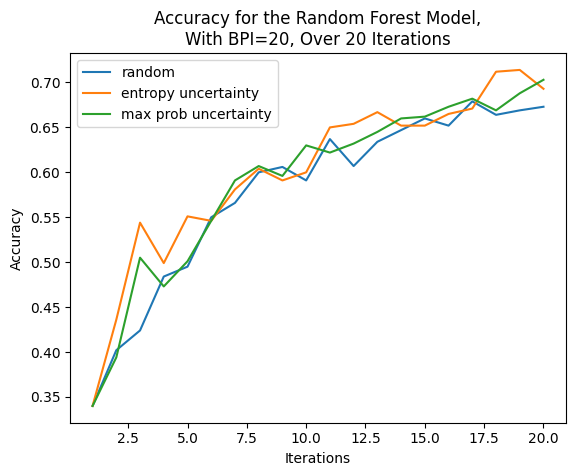

In [32]:
run_AL_and_plot_accuracy(model_name="Random Forest", iterations=20, budget_per_iter=20)

### **SVC**

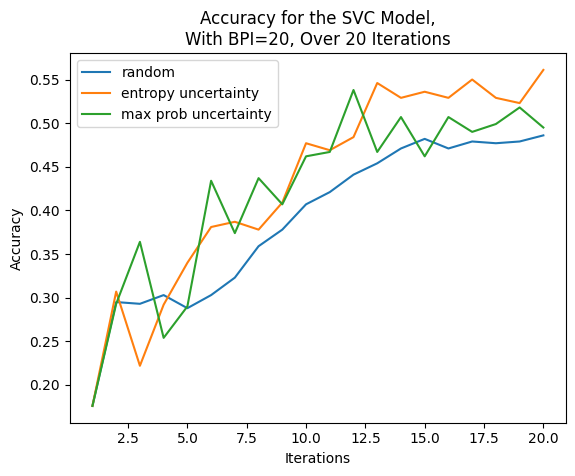

In [33]:
run_AL_and_plot_accuracy(model_name="SVC", iterations=20, budget_per_iter=20)

### **Multiclass Logistic Regression**

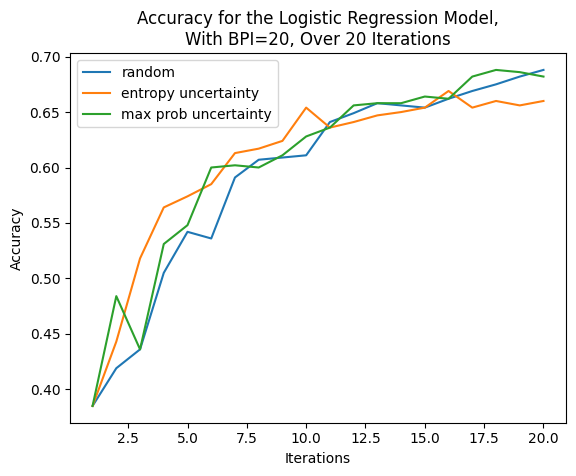

In [34]:
run_AL_and_plot_accuracy(model_name="Logistic Regression", iterations=20, budget_per_iter=20)

### **Conclusions:**

From the graphs above we can conclude the following:

* The performance of all three sampling methods seems to be quite similar, across all models and al iterations (apart from the random sampling method under the SVC model, as an exception).

* After about 20 iterations, the three models seem to reach a plateau in terms of accuracy.

* The Random Forest and Logistic Regression models seem to yield the best accuracy (up to ~70%), while the SVC model appears to yield poorer accuracy (up to ~55%).


## **Budget per Iteration Comparison**

In this section, we will experiment with the 'budget per iteration' (BPI) parameter. Specifically, we will plot the accuracies per iteration when using the Random Forest model.

**Remarks**

* We chose said model since it perforemd quite decently (compared to the rest).

* The number of iterations will be set as 20.

### **BPI = 5**

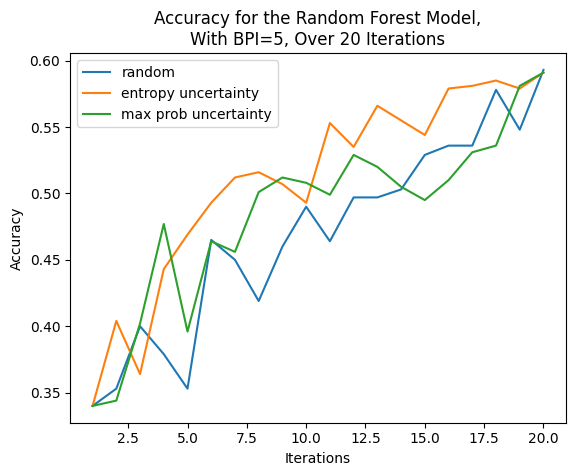

In [35]:
run_AL_and_plot_accuracy(model_name="Random Forest", iterations=20, budget_per_iter=5)

### **BPI=20**

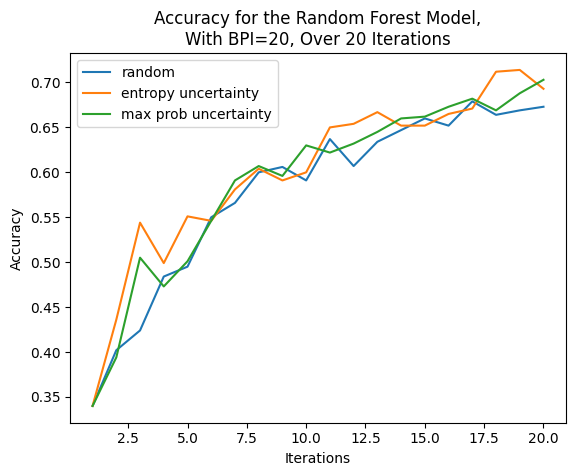

In [36]:
run_AL_and_plot_accuracy(model_name="Random Forest", iterations=20, budget_per_iter=20)

### **BPI = 50**

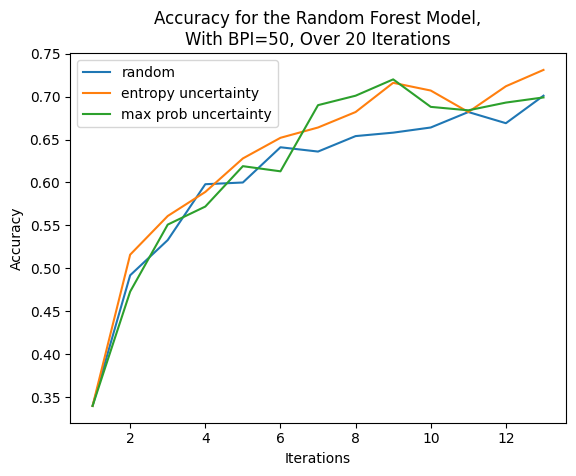

In [37]:
run_AL_and_plot_accuracy(model_name="Random Forest", iterations=20, budget_per_iter=50)

### **Conclusions**

From the graphs above we can conclude the following:

* It appears that the accuracy’s variance of consecutive iterations is much larger with BPI=5 as opposed to BPI=50. That is, the results are much less consistent with BPI=5.

* It appears that for each sampling method, the model’s best result is achieved with BPI=50 (~70% accuracy as opposed to ~60).

* With BPI=50, notice that the number of iterations is not 20, but 12. This is because the budget ran out after said number of iterations.

* It appears that for each sampling method, the model’s best results are approximately the same with BPI=20 and BPI=50 (~70% accuracy). However, with BPI=50 the model archives this result with roughly half the number of iterations (12 as opposed to 20).
